In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torchvision
from torch import nn

In [8]:
#0. Importing and setting up PyTorch diagnostic code

In [9]:
if torch.backends.mps.is_available():
    device = "mps" 
    print("mps is available. GPU can be used with PyTorch on Apple Silicon.")
    
    # Optionally, you can get the MPS device name
    mps_device = torch.device("mps")
    print(f"Using device: {mps_device}")
else:
    device = "cpu"
    print("mps is not available. GPU cannot be used with PyTorch on Apple Silicon.")

mps is available. GPU can be used with PyTorch on Apple Silicon.
Using device: mps


In [10]:
#our dataset is a subset of the food 101 dataset
#using only 3 classes of food and 10% of the images (100 images per class)

In [11]:
import requests
import zipfile
from pathlib import Path

data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

if image_path.is_dir():
    print(f"{image_path} directory already exists...skipping download")
else:
    print(f"{image_path} does not exit, creating one")
    image_path.mkdir(parents=True, exist_ok=True)

#download pizza, steak and sushi data
with open(data_path / "pizza_steak_sushi.zip","wb") as f:
    requests = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
    print(f"Downloading pizza, steak, sushi data")
    f.write(requests.content)

#unzip the file
with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip","r") as zip_ref: 
    print(f"unzipping pizza, steak and sushi data")
    zip_ref.extractall(image_path)

data/pizza_steak_sushi directory already exists...skipping download
unzipping pizza, steak and sushi data


EDA

In [12]:
import os
def walk_through_dir(dir_path):
    """walks through dir_path returning its contents"""
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}.")

In [13]:
walk_through_dir(dir_path=image_path)

There are 2 directories and 0 images in data/pizza_steak_sushi.
There are 3 directories and 0 images in data/pizza_steak_sushi/test.
There are 0 directories and 19 images in data/pizza_steak_sushi/test/steak.
There are 0 directories and 31 images in data/pizza_steak_sushi/test/sushi.
There are 0 directories and 25 images in data/pizza_steak_sushi/test/pizza.
There are 3 directories and 0 images in data/pizza_steak_sushi/train.
There are 0 directories and 75 images in data/pizza_steak_sushi/train/steak.
There are 0 directories and 72 images in data/pizza_steak_sushi/train/sushi.
There are 0 directories and 78 images in data/pizza_steak_sushi/train/pizza.


In [14]:
train_dir = image_path / "train"
test_dir = image_path/ "test"

train_dir

PosixPath('data/pizza_steak_sushi/train')

In [15]:
image_path

PosixPath('data/pizza_steak_sushi')

pizza
Random image path: data/pizza_steak_sushi/test/pizza/2236338.jpg
Image class: pizza
Image height: 512
Image width: 512


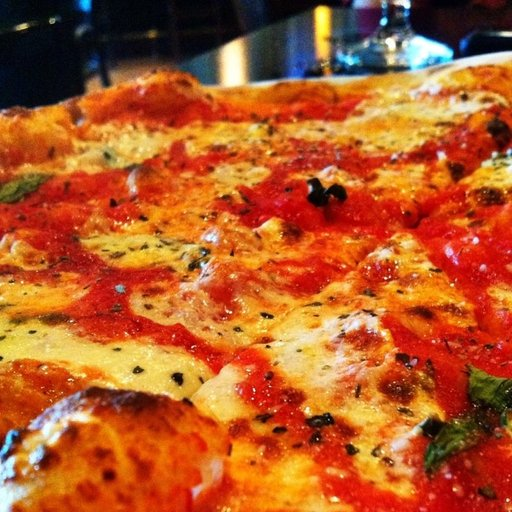

In [16]:
#visualising  an image
import random
from PIL import Image

random.seed(42)         #if want to change the image need remove this random seed and run agn

#get all the imgae paths
image_path_list = list(image_path.glob("*/*/*.jpg"))

#pick a random imgae
random_image_path = random.choice(image_path_list)
random_image_path

#get the image class from the path name
image_class = random_image_path.parent.stem
print(image_class)

#open image
img = Image.open(random_image_path)

#print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

(-0.5, 511.5, 511.5, -0.5)

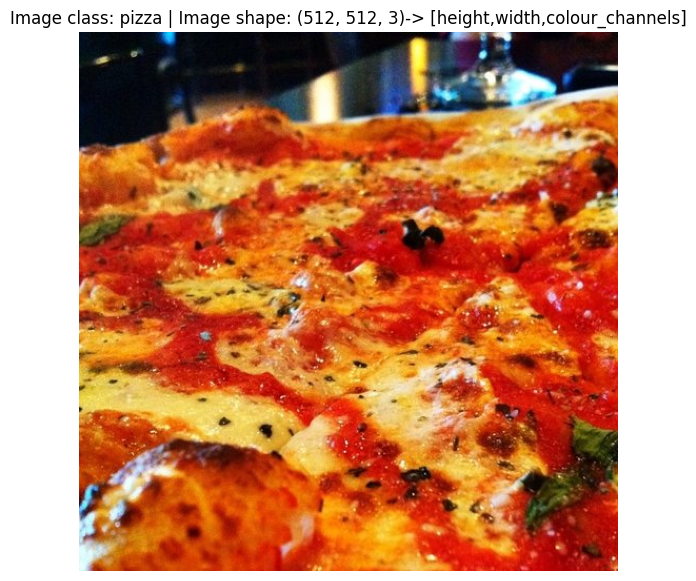

In [17]:
# try to visualise an image with matplotlib
import matplotlib.pyplot as plt

#turn image into an array
img_as_array = np.asarray(img)

#plto the image with matplotlib
plt.figure(figsize=(10,7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape}-> [height,width,colour_channels]")
plt.axis(False)

In [18]:
img_as_array

array([[[  7,  18,  38],
        [  5,  16,  36],
        [  2,  13,  31],
        ...,
        [ 17,   8,   9],
        [ 12,   6,   8],
        [  8,   4,   5]],

       [[  2,  13,  33],
        [  2,  13,  33],
        [  2,  13,  31],
        ...,
        [ 18,   9,  10],
        [ 17,  11,  13],
        [ 16,  12,  13]],

       [[  0,  11,  29],
        [  1,  12,  30],
        [  3,  14,  32],
        ...,
        [ 17,   8,   9],
        [ 16,  10,  12],
        [ 15,  11,  12]],

       ...,

       [[226, 249, 255],
        [229, 253, 255],
        [230, 254, 254],
        ...,
        [252, 148,  95],
        [242, 138,  83],
        [234, 131,  73]],

       [[222, 247, 254],
        [224, 252, 255],
        [226, 255, 253],
        ...,
        [238, 133,  88],
        [195,  88,  42],
        [169,  62,  16]],

       [[219, 246, 253],
        [224, 252, 255],
        [224, 254, 252],
        ...,
        [255, 156, 116],
        [207, 100,  58],
        [163,  54,  13]]

transforming the data


In [19]:
#turn your target data into tensors
#turn it into a 'torch.utils.data.Dataset' and subsequently a 'torch.utils.data.Datalaoder'

In [20]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [21]:
#write a transform for image
data_transform = transforms.Compose([
    #resize the images to 64x64
    transforms.Resize(size=(64,64)),
    #flip tge images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5),
    #turn the image into a torch tensor
    transforms.ToTensor()
])

In [23]:
data_transform(img)

tensor([[[0.0157, 0.0157, 0.0118,  ..., 0.2314, 0.1922, 0.1020],
         [0.0157, 0.0157, 0.0157,  ..., 0.1137, 0.1059, 0.1216],
         [0.0157, 0.0235, 0.0941,  ..., 0.1098, 0.1255, 0.1569],
         ...,
         [0.8549, 0.8275, 0.8039,  ..., 0.4353, 0.6353, 0.6902],
         [0.8667, 0.8392, 0.7922,  ..., 0.4824, 0.6235, 0.7412],
         [0.8627, 0.7333, 0.7255,  ..., 0.6627, 0.6549, 0.8000]],

        [[0.0588, 0.0510, 0.0392,  ..., 0.0510, 0.0471, 0.0392],
         [0.0549, 0.0471, 0.0431,  ..., 0.0431, 0.0431, 0.0549],
         [0.0667, 0.0706, 0.1176,  ..., 0.0510, 0.0471, 0.0510],
         ...,
         [0.9529, 0.8824, 0.8118,  ..., 0.1098, 0.0627, 0.0627],
         [0.9804, 0.8510, 0.6353,  ..., 0.0667, 0.0824, 0.2353],
         [0.9412, 0.5451, 0.3176,  ..., 0.0745, 0.0980, 0.3098]],

        [[0.1176, 0.0745, 0.0667,  ..., 0.0588, 0.0510, 0.0392],
         [0.1137, 0.0863, 0.0784,  ..., 0.0431, 0.0392, 0.0510],
         [0.0941, 0.0941, 0.1216,  ..., 0.0588, 0.0510, 0.

visualize transformed images

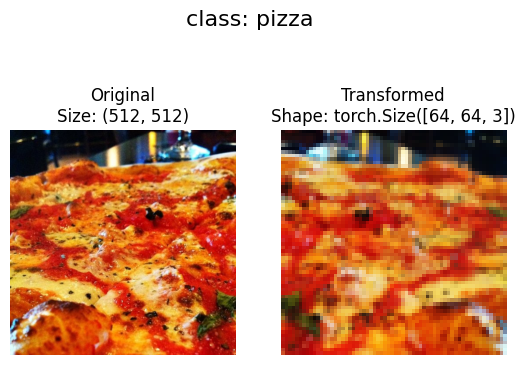

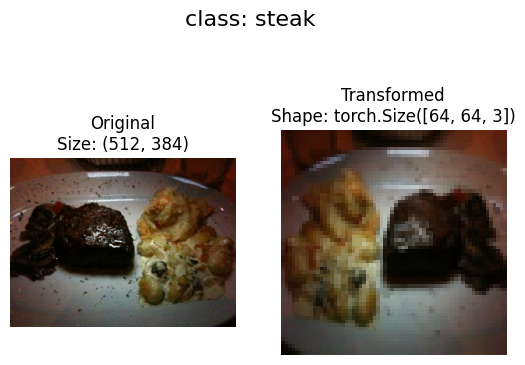

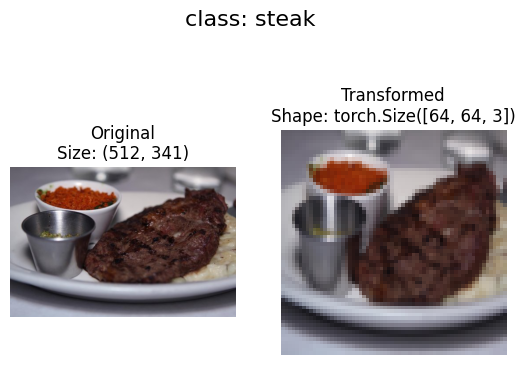

In [26]:
def plot_transformed_images(image_paths, transform, n=3, seed=42):
    """selects random imgaes from a path of images and loads/transforms them
    then place the original vs the transformed version"""
    if seed:
        random.seed(42)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(nrows=1, ncols =2)
            ax[0].imshow(f)
            ax[0].set_title(f"Original\nSize: {f.size}")
            ax[0].axis(False)

            #transform and plot the target image
            transformed_image = transform(f).permute(1,2,0)
            ax[1].imshow(transformed_image)
            ax[1].set_title(f"Transformed\nShape: {transformed_image.shape}")
            ax[1].axis("off")

            fig.suptitle(f"class: {image_path.parent.stem}",fontsize = 16)

plot_transformed_images(image_paths =image_path_list,
                        transform = data_transform,
                        n=3,
                        seed=42)

In [27]:
#smaller imgae so the model will be able to compute faster but might lose some accuracy as there
#is lesser information

#option 1: loading image data using 'ImageFolder'

In [66]:
from torchvision import datasets
train_data = datasets.ImageFolder(root= train_dir,
                                  transform=data_transform,         #transform for the data
                                  target_transform=None)            #transform for the label

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform)

train_data,test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [67]:
#get class names as a list
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [68]:
#get class names as a dictionary
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [69]:
#check the lengths of our dataset
len(train_data), len(test_data)

(225, 75)

In [70]:
#index on the train_data dataset to get a single image and label
img, label =train_data[0][0],train_data[0][1]
print(f"Image tensor:\n {img}")
print(f"Image shapes: {img.shape}")
print(f"Imgage datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image tensor:
 tensor([[[0.1137, 0.1020, 0.0980,  ..., 0.1255, 0.1216, 0.1176],
         [0.1059, 0.0980, 0.0980,  ..., 0.1294, 0.1294, 0.1294],
         [0.1020, 0.0980, 0.0941,  ..., 0.1333, 0.1333, 0.1333],
         ...,
         [0.1098, 0.1098, 0.1255,  ..., 0.1686, 0.1647, 0.1686],
         [0.0902, 0.0941, 0.1098,  ..., 0.1686, 0.1647, 0.1686],
         [0.0863, 0.0863, 0.0980,  ..., 0.1686, 0.1647, 0.1647]],

        [[0.0745, 0.0706, 0.0745,  ..., 0.0588, 0.0588, 0.0588],
         [0.0745, 0.0706, 0.0745,  ..., 0.0627, 0.0627, 0.0627],
         [0.0706, 0.0745, 0.0745,  ..., 0.0706, 0.0706, 0.0706],
         ...,
         [0.1255, 0.1333, 0.1373,  ..., 0.2510, 0.2392, 0.2392],
         [0.1098, 0.1176, 0.1255,  ..., 0.2510, 0.2392, 0.2314],
         [0.1020, 0.1059, 0.1137,  ..., 0.2431, 0.2353, 0.2275]],

        [[0.0941, 0.0902, 0.0902,  ..., 0.0157, 0.0196, 0.0196],
         [0.0902, 0.0863, 0.0902,  ..., 0.0196, 0.0157, 0.0196],
         [0.0902, 0.0902, 0.0902,  ..., 0.0

original shape: torch.Size([3, 64, 64])->[c,h,w]
Image permute: torch.Size([64, 64, 3])->[h,w,c]


Text(0.5, 1.0, 'pizza')

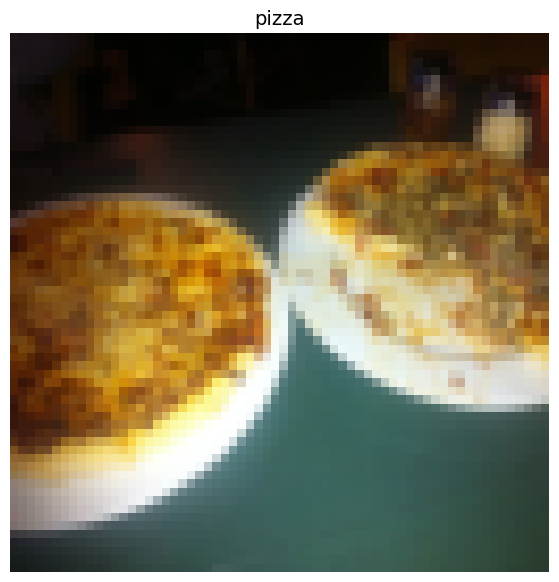

In [71]:
#rearrange the order dimensions 
img_permute = img.permute(1,2,0)

#print out differenet shapes
print(f"original shape: {img.shape}->[c,h,w]")
print(f'Image permute: {img_permute.shape}->[h,w,c]')

#plot the image
plt.figure(figsize=(10,7))
plt.imshow(img_permute)
plt.axis("off")
plt.title(class_names[label],fontsize = 14)

Turning datasets into dataloader

In [72]:
import os
os.cpu_count()

10

In [73]:
#turn train and test datasets into dataloaders
from torch.utils.data import DataLoader
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=32,
                              num_workers=os.cpu_count(),
                              shuffle=True)
test_dataloader = DataLoader(dataset=test_data,
                             batch_size=32,
                             num_workers=os.cpu_count(),
                             shuffle=False)

In [74]:
train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x176313ad0>,
 <torch.utils.data.dataloader.DataLoader at 0x176334e90>)

In [75]:
len(train_dataloader), len(test_dataloader)

(8, 3)

In [76]:
img, label = next(iter(train_dataloader))

print(f"Image shape: {img.shape}-> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([32, 3, 64, 64])-> [batch_size, color_channels, height, width]
Label shape: torch.Size([32])


#option 2: loading image data with a custom 'Dataset'

In [77]:
"""
1. want to be able to load images from file
2. want to be able to get class names from the Dataset
3. want to be able to get classes as dictionary from dataset
"""

'\n1. want to be able to load images from file\n2. want to be able to get class names from the Dataset\n3. want to be able to get classes as dictionary from dataset\n'

In [78]:
import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

In [79]:
#instance of torchvision.datasets.ImageFolder()
train_data.classes, train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

In [80]:
#creating a helper function to get class names
"""
1. get the class names using 'os.scandir()' to traverse a target directory (ideally
the directory is in standard image classification format).
2.raise an error if the class names arent found (if thos happens, there might be something wrong with the 
directory structure).
3.turn the class names into a dict and a list and return them
"""


"\n1. get the class names using 'os.scandir()' to traverse a target directory (ideally\nthe directory is in standard image classification format).\n2.raise an error if the class names arent found (if thos happens, there might be something wrong with the \ndirectory structure).\n3.turn the class names into a dict and a list and return them\n"

In [81]:
target_directory = train_dir
print(f"Target dir: {target_directory}")

class_names_found = sorted ([entry.name for entry in list(os.scandir(target_directory))])
class_names_found

Target dir: data/pizza_steak_sushi/train


['pizza', 'steak', 'sushi']

In [82]:
def find_classes(directory: str)->Tuple[list[str],Dict[str,int]]:
    """finds the class folder names inn a target directory"""
    #1. get the class names by scanning the directory
    classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())

    #2. raise an error if class names could not be found
    if not classes:
        raise FileNotFoundError(f"couldn't find any classes in {directory}...please check file structure.")
    
    #3. create a dictionary of index labels (computers prefer numbers rather than strings as labels)
    class_to_idx = {class_name: i for i, class_name in enumerate(classes)}
    return classes, class_to_idx

In [83]:
find_classes(target_directory)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

In [84]:
#create a custom 'Dataset' to replicate 'ImageFolder'
from torch.utils.data import Dataset

#1. subclass torch.utils.data.Dataset
class ImageFolderCustom(Dataset):
    #2. initialize our custom dataset
    def __init__(self,targ_dir:str,transform=None):
        #3. create class attributes
        self.paths = list(pathlib.Path(targ_dir).glob("*/*.jpg"))
        #setup transforms
        self.transform = transform
        #create classes and class_to_idx
        self.classes, self.class_to_idx = find_classes(targ_dir)

    #4. create a function to load images
    def load_image(self,index: int)->Image.Image:
        "opens an image via a path and returns it."
        image_path = self.paths[index]
        return Image.open(image_path)
    
    #5. overwrite __len__()
    def __len__(self)-> int:
        "returns the total number of samples."
        return len(self.paths)
    
    #6. overwrite __getitem__() method to return our particular sample
    def __getitem__(self, index:int) -> Tuple[torch.tensor, int]:
        "returns 1 sample of data and label (x,y)."
        img = self.load_image(index)
        class_name = self.paths[index].parent.name #expects path in format: data_folder/class_name/image.jpg
        class_idx = self.class_to_idx[class_name]

        #transform if necessay
        if self.transform:
            return self.transform(img), class_idx #return data label (x,y)
        
        else:
            return img, class_idx

